Project Overview
This project predicts the likelihood of diabetes with a binary outcome from a clinical measurements using machine learning. It follows the full Data Science Life Cycle

1- Data Source and Collection
link for dataset: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
local path: data/raw/diabetes.csv

In [6]:
#imports and setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ( classification_report, confusion_matrix, roc_auc_score, roc_curve,
 precision_recall_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from joblib import dump


RANDOM_STATE= 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", None)

csv_path=("../data/raw/diabetes.csv")
df= pd.read_csv(csv_path)
print("Cvs file:", csv_path)
df.head()

Cvs file: ../data/raw/diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


2- Data Exploration

In [7]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
df.columns
for col in df.columns:
    zero=(df[col]==0).sum()
    print( f"Missing Values per column:'{col}':{zero}")

# outcome count per class sorted
class_counts = df['Outcome'].value_counts().sort_index()
class_percentage = (class_counts / len(df) * 100).round(2)
print("\nClass Distribution (counts):\n", class_counts)
print("\nClass Distribution (percent):\n", class_percentage)
df.describe()

Shape: (768, 9)

Dtypes:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
Missing Values per column:'Pregnancies':111
Missing Values per column:'Glucose':5
Missing Values per column:'BloodPressure':35
Missing Values per column:'SkinThickness':227
Missing Values per column:'Insulin':374
Missing Values per column:'BMI':11
Missing Values per column:'DiabetesPedigreeFunction':0
Missing Values per column:'Age':0
Missing Values per column:'Outcome':500

Class Distribution (counts):
 Outcome
0    500
1    268
Name: count, dtype: int64

Class Distribution (percent):
 Outcome
0    65.1
1    34.9
Name: count, dtype: float64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


3- Data Cleaning and Preprocessing

In [8]:
df_clean = df.copy()
zero_as_nan =["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]


print("Zero counts before:")
print((df_clean[zero_as_nan]==0).sum())

df_clean[zero_as_nan]=df_clean[zero_as_nan].replace(0, np.nan)

print("\nMissing after zero->NaN:")
print(df_clean[zero_as_nan].isna().sum())

df_clean[zero_as_nan]=df_clean[zero_as_nan].fillna(df_clean[zero_as_nan].median())

print("\nMissing after imputation (should be 0):")
print(df_clean[zero_as_nan].isna().sum())

processed_path= "../data/processed/diabetes_clean.csv"
df_clean.to_csv(processed_path, index=False)
print("\nSaved cleaned data to:", processed_path)

df_clean.head()

Zero counts before:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Missing after zero->NaN:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Missing after imputation (should be 0):
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

Saved cleaned data to: ../data/processed/diabetes_clean.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


4- Data Visualisation

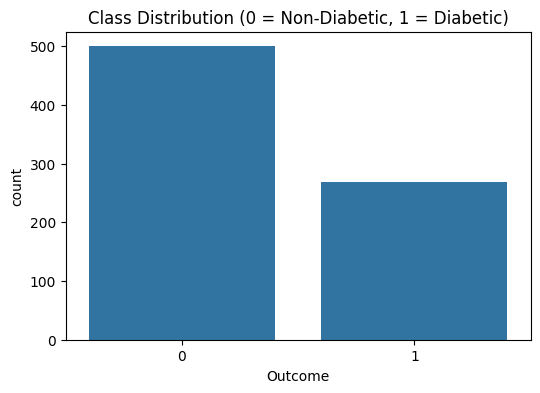

In [9]:
#Bar Chart
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title("Class Distribution (0 = Non-Diabetic, 1 = Diabetic)")
plt.show()

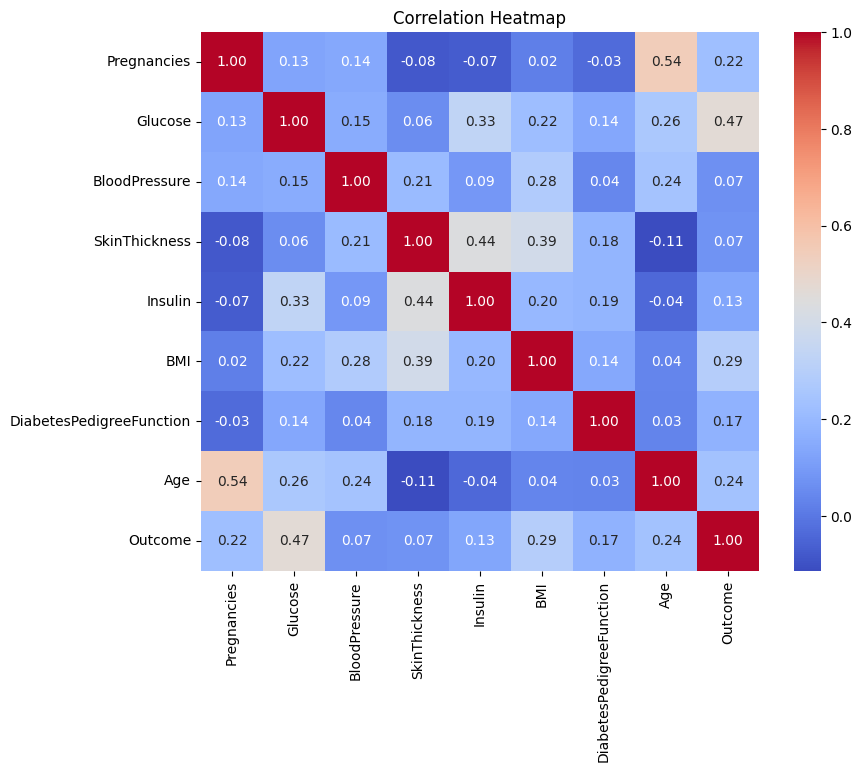

In [10]:
#Correlation heatmap
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

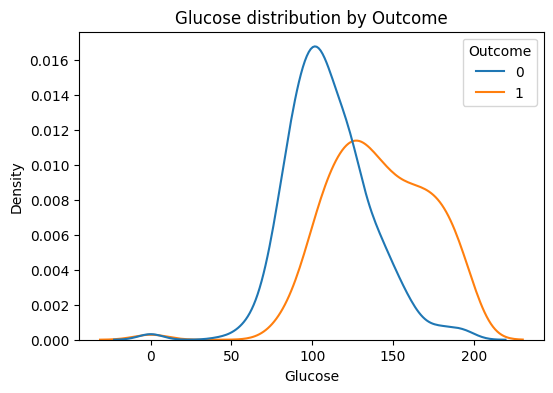

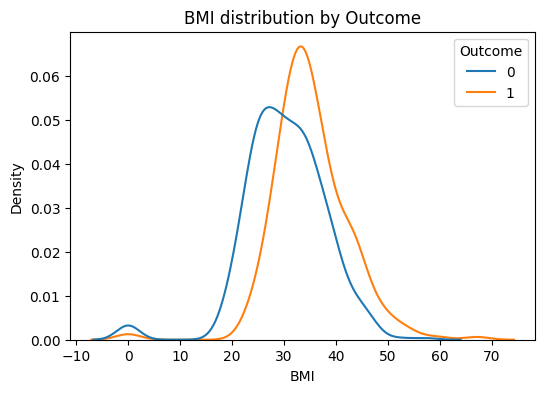

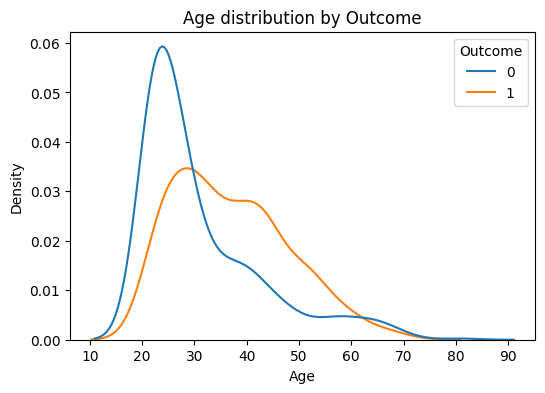

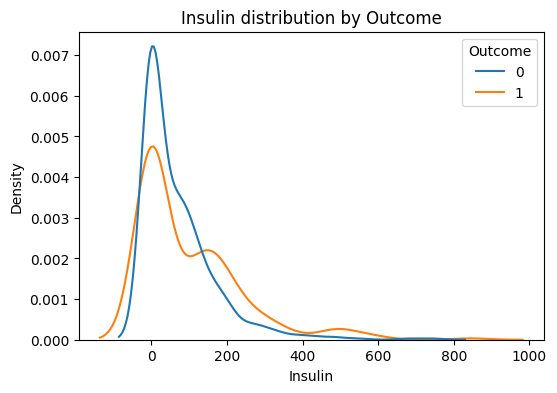

In [11]:
#Key feature distributions by Outcome
for col in ["Glucose","BMI", "Age", "Insulin"]:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.kdeplot(data=df, x=col, hue="Outcome", common_norm=False)
        plt.title(f"{col} distribution by Outcome")
        plt.show()

5- Feature Engineering and Split

In [21]:
x= df_clean.drop(columns=["Outcome"])
y= df_clean["Outcome"]

x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scalar= StandardScaler()
x_train_scaled= scalar.fit_transform(x_train)
x_test_scaled= scalar.transform(x_test)

print("x_train shape:", x_train.shape, "| x_test shape:", x_test.shape)
print("y_train mean:", y_train.mean().round(3), "| y_test mean:", y_test.mean().round(3))



x_train shape: (614, 8) | x_test shape: (154, 8)
y_train mean: 0.349 | y_test mean: 0.351


6- Modeling

In [25]:
models={
    "LogisticRegression":LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE),
    "RandomForest":RandomForestClassifier(n_estimators=300,random_state=RANDOM_STATE, class_weight="balanced")

}

results={}

for name, model in models.items():
    if name=="LogisticRegression":
        model.fit(x_train_scaled, y_train)
        y_pred= model.predict(x_test_scaled)
        y_prob= model.predict_proba(x_test_scaled)[:,1]
    else:
        model.fit(x_train, y_train)
        y_pred= model.predict(x_test)
        y_prob= model.predict_proba(x_test)[:,1]

    print(f"==={name}===")
    print(classification_report(y_test, y_pred, digits=3))
    roc= roc_auc_score(y_test, y_prob)
    print("ROC AUC:", round(roc, 3))
    print()

    results[name]={"model": model, "y_pred":y_pred,"y_prob":y_prob}

===LogisticRegression===
              precision    recall  f1-score   support

           0      0.824     0.750     0.785       100
           1      0.603     0.704     0.650        54

    accuracy                          0.734       154
   macro avg      0.714     0.727     0.717       154
weighted avg      0.747     0.734     0.738       154

ROC AUC: 0.813

===RandomForest===
              precision    recall  f1-score   support

           0      0.780     0.850     0.813       100
           1      0.667     0.556     0.606        54

    accuracy                          0.747       154
   macro avg      0.723     0.703     0.710       154
weighted avg      0.740     0.747     0.741       154

ROC AUC: 0.816



7- Evaluation and Interpretation

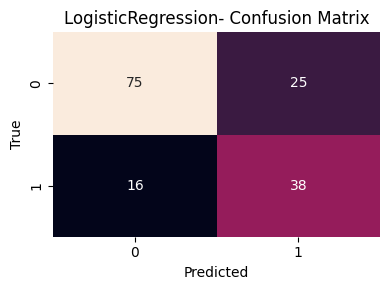

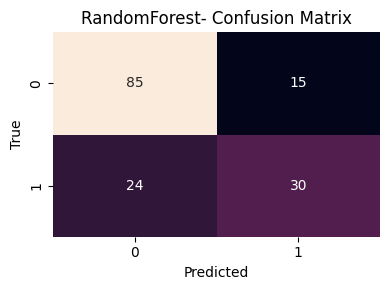

In [26]:
for name, out in results.items():
    cm= confusion_matrix(y_test, out["y_pred"])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"{name}- Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

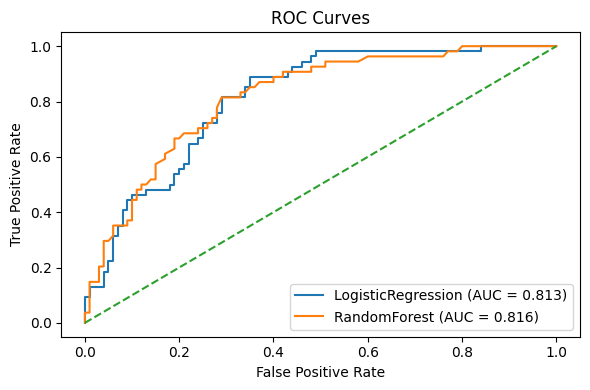

In [27]:
#ROC curves
plt.figure(figsize=(6,4))
for name, out in results.items():
    fpr, tpr, _= roc_curve(y_test, out["y_prob"])
    roc_auc= auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()